In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


## Load data

In [2]:
import pathlib
datadir = pathlib.Path('/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined').with_suffix('')
datadir

PosixPath('/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined')

In [3]:
SEED = 4211
VAL_SPLIT = 0.2
BATCH_SIZE=16

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(datadir, image_size=(300, 300), subset="training", validation_split=VAL_SPLIT, seed=SEED, batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(datadir, image_size=(300, 300), subset="validation", validation_split=VAL_SPLIT, seed=SEED, batch_size=BATCH_SIZE)
print(train_ds)
print(val_ds)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Build and training

In [5]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.max_pool = keras.layers.MaxPool2D(2, strides=2, padding='same')
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False), 
                               keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        x = inputs
        for layer in self.main_layers:
            x = layer(x)
        z = inputs
        for layer in self.skip_layers:
            z = layer(z)
        outputs = x + z
        return self.activation(self.max_pool(x + z))

In [6]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
mini_resnet = keras.models.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.Lambda(lambda x: tf.image.crop_to_bounding_box(x, 60, 60, 180, 180)),
    keras.layers.Conv2D(16, 6, strides=2, use_bias=False, input_shape=(180, 180, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    ResidualUnit(32, strides=2),
    ResidualUnit(32, strides=1),
    ResidualUnit(64, strides=2),
    ResidualUnit(64, strides=1),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam()
mini_resnet.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, monitor="val_accuracy", restore_best_weights=True)

history = mini_resnet.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[callback])

Epoch 1/30
500/500 [==============================] - 86s 166ms/step - loss: 1.5473 - accuracy: 0.4899 - val_loss: 1.4643 - val_accuracy: 0.4985
Epoch 2/30
500/500 [==============================] - 71s 143ms/step - loss: 0.7525 - accuracy: 0.7645 - val_loss: 0.9571 - val_accuracy: 0.7085
Epoch 3/30
500/500 [==============================] - 71s 142ms/step - loss: 0.4977 - accuracy: 0.8478 - val_loss: 0.6449 - val_accuracy: 0.8080
Epoch 4/30
500/500 [==============================] - 72s 143ms/step - loss: 0.3646 - accuracy: 0.8905 - val_loss: 0.7652 - val_accuracy: 0.7555
Epoch 5/30
500/500 [==============================] - 72s 144ms/step - loss: 0.2871 - accuracy: 0.9137 - val_loss: 0.5239 - val_accuracy: 0.8500
Epoch 6/30
500/500 [==============================] - 78s 157ms/step - loss: 0.2248 - accuracy: 0.9339 - val_loss: 0.4448 - val_accuracy: 0.8860
Epoch 7/30
500/500 [==============================] - 77s 155ms/step - loss: 0.1969 - accuracy: 0.9414 - val_loss: 0.7525 - val_ac

In [9]:
mini_resnet.save("Drug_Classification_MiniResNet_v1.h5")

Text(0.5, 0, 'Epoch')

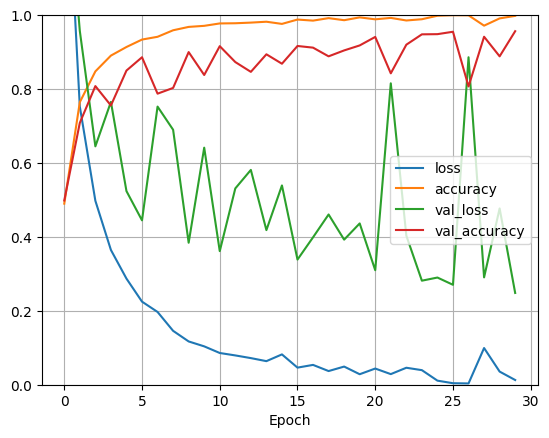

In [11]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epoch')

## Testing Prediction

In [50]:
import numpy as np
test_img1_path = "/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/images_raw/00000000.jpg"
test_img1 = tf.keras.utils.load_img(
    test_img1_path,
    grayscale=False,
    color_mode='rgb',
    target_size=(300,300),
    interpolation='nearest',
    keep_aspect_ratio=False
)
input_arr = tf.keras.utils.img_to_array(test_img1)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = mini_resnet.predict(input_arr)

1/1 [==============================] - 0s 190ms/step


In [53]:
class_names = ['Alaxan','Bactidol','Bioflu','Biogesic','DayZinc','Decolgen','Fish Oil','Kremil S','Medicol','Neozep']

In [54]:
class_names[predictions.argmax()]

'Decolgen'

## Inferencing Function

For this task, the model is trained to recognize one type of drug at a time only.
The below inference results merely show the drugs with highest probabilities to be recognized in the picture

In [67]:
def inference(image_path):
    image = tf.keras.utils.load_img(image_path, grayscale=False, color_mode='rgb', target_size=(300,300), interpolation='nearest', keep_aspect_ratio=False)
    input_arr = tf.keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions = mini_resnet.predict(input_arr)
    l = sorted(list(enumerate(list(predictions[0]))), key=lambda x: x[1], reverse=True)[:3]
    d = {}
    for item in l:
        class_name = class_names[item[0]]
        prob = item[1] * 100
        d[class_name] = prob
    return d
#         print(f"{class_name}: {prob}")

inference(test_img1_path)

1/1 [==============================] - 0s 28ms/step


{'Decolgen': 99.99796152114868,
 'Fish Oil': 0.0019392698959563859,
 'Alaxan': 9.244752732229244e-05}

In [69]:
inference('/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/images_raw/00000002.jpg')

1/1 [==============================] - 0s 29ms/step


{'Bioflu': 87.74465918540955,
 'Kremil S': 11.256224662065506,
 'Neozep': 0.9046308696269989}

1/1 [==============================] - 0s 30ms/step
{'Bioflu': 87.74465918540955, 'Kremil S': 11.256224662065506, 'Neozep': 0.9046308696269989}




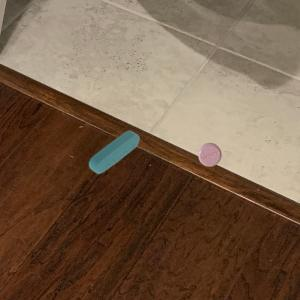

In [71]:
def load_img_and_pred(img_path):
    image = tf.keras.utils.load_img(img_path, grayscale=False, color_mode='rgb', target_size=(300,300), interpolation='nearest', keep_aspect_ratio=False)
    pred = inference(img_path)
    print(pred)
    print("\n")
    return image

load_img_and_pred('/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/images_raw/00000002.jpg')

1/1 [==============================] - 0s 30ms/step
{'Fish Oil': 99.05055165290833, 'Neozep': 0.49264654517173767, 'Decolgen': 0.4050630610436201}




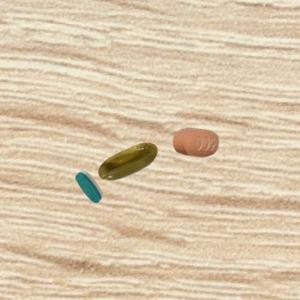

In [73]:
load_img_and_pred('/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/images_raw/00000035.jpg')